# Homework 1

The goal of this assignment is to construct, analyze, and publish a dataset of monthly article traffic for a select set of pages from English Wikipedia from January 1, 2015 through September 30, 2022. Your notebook(s) and your data files will be uploaded to a repository of your choosing. You will submit a  link to your repository to enable grading of this assignment. The purpose of the assignment is to develop and follow best practices for open scientific research.

# Step 1: Data Acquisition

In order to measure article traffic from 2015-2022, you will need to collect data from the Pageviews API. The Pageviews API (documentation, endpoint) provides access to desktop, mobile web, and mobile app traffic data from July 2015 through the previous complete month. 

To get you started, you can refer to this example notebook that contains sample code for the API call. This sample code is licensed CC0 so feel free to reuse any of the code in that notebook without attribution.
You will be collecting counts of pageviews using a specified subset of Wikipedia article pages. This is a subset of the English Wikipedia that represents a large number of dinosaur related articles.

You will use the same article subset to generate several related data sets. All of the data sets are time series of monthly activity. For all of the data sets we are only interested in actual user pageview requests. The three resulting datasets should be saved as a JSON files ordered using article titles as a key for the resulting time series data. You should store the time series data as returned from the API, with the exception of removing the ‘access’ field as it is misleading for mobile and cumulative files.


### 1a) Importing the required libraries

- The below libraries are imported to help in the execution of various tasks as mentioned along the notebook.

In [93]:
import json, time, urllib.parse
import requests
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from datetime import datetime

### 1b) Configuring the API parameters

###### License
The below code snippet is taken from the code example that was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - May 5, 2022



- Reading the cleaned .csv file locally

In [3]:
df = pd.read_csv('dinosaur_genera.cleaned.SEPT.2022.csv')

In [4]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens

REQUEST_HEADERS = {
    'User-Agent': '<nmohan@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# The name of the dino from the input file is saved as a list of Article Titles
ARTICLE_TITLES = df['name']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this will be changed for different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # For this examples the start date is July 2015
    "end":         "2022093000"    # For this example the end date is Sept 2022
}


- The API request will be made using one procedure. The idea is to make this reusable. The procedure is parameterized, but relies on the constants above for the important parameters. The underlying assumption is that this will be used to request data for a set of article pages. 

In [5]:
def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(article_title.replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


### 1c) Extracting data from Wikipedia

- The below code runs through various access types and fetches data for all the given article titles.
We have added a try & except block to ensure the code does not break due to a failure or latency at the server end.

In [7]:
access_type = ['mobile-app', 'mobile-web', 'desktop', 'all-access']
views_list = []
for i in range(len(ARTICLE_TITLES)):
    # Creating an exception block to avoid breaking of code
    # There are several APIs where the data isn't loading
    try: 
        for j in access_type:
            ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE['access'] = j
            views = request_pageviews_per_article(ARTICLE_TITLES[i])
            views_list.append(pd.json_normalize(views['items']))
            #print('Data fetched for: ', ARTICLE_TITLES[i] )
    except:
        print("Could not get data for: ",i)

Data fetched for:  Coelosaurus antiquus
Data fetched for:  Coelosaurus antiquus
Data fetched for:  Coelosaurus antiquus
Data fetched for:  Coelosaurus antiquus
Data fetched for:  Aachenosaurus
Data fetched for:  Aachenosaurus
Data fetched for:  Aachenosaurus
Data fetched for:  Aachenosaurus
Data fetched for:  Aardonyx
Data fetched for:  Aardonyx
Data fetched for:  Aardonyx
Data fetched for:  Aardonyx
Data fetched for:  Abdarainurus
Data fetched for:  Abdarainurus
Data fetched for:  Abdarainurus
Data fetched for:  Abdarainurus
Data fetched for:  Abditosaurus
Data fetched for:  Abditosaurus
Data fetched for:  Abditosaurus
Data fetched for:  Abditosaurus
Data fetched for:  Abelisaurus
Data fetched for:  Abelisaurus
Data fetched for:  Abelisaurus
Data fetched for:  Abelisaurus
Data fetched for:  Abrictosaurus
Data fetched for:  Abrictosaurus
Data fetched for:  Abrictosaurus
Data fetched for:  Abrictosaurus
Data fetched for:  Abrosaurus
Data fetched for:  Abrosaurus
Data fetched for:  Abros

Data fetched for:  Alvarezsaurus
Data fetched for:  Alwalkeria
Data fetched for:  Alwalkeria
Data fetched for:  Alwalkeria
Data fetched for:  Alwalkeria
Data fetched for:  Alxasaurus
Data fetched for:  Alxasaurus
Data fetched for:  Alxasaurus
Data fetched for:  Alxasaurus
Data fetched for:  Amanzia
Data fetched for:  Amanzia
Data fetched for:  Amanzia
Data fetched for:  Amanzia
Data fetched for:  Amargasaurus
Data fetched for:  Amargasaurus
Data fetched for:  Amargasaurus
Data fetched for:  Amargasaurus
Data fetched for:  Amargatitanis
Data fetched for:  Amargatitanis
Data fetched for:  Amargatitanis
Data fetched for:  Amargatitanis
Data fetched for:  Amazonsaurus
Data fetched for:  Amazonsaurus
Data fetched for:  Amazonsaurus
Data fetched for:  Amazonsaurus
Data fetched for:  Ambopteryx
Data fetched for:  Ambopteryx
Data fetched for:  Ambopteryx
Data fetched for:  Ambopteryx
Data fetched for:  Ampelosaurus
Data fetched for:  Ampelosaurus
Data fetched for:  Ampelosaurus
Data fetched fo

Data fetched for:  Arkharavia
Data fetched for:  Arkharavia
Data fetched for:  Arkharavia
Data fetched for:  Arrhinoceratops
Data fetched for:  Arrhinoceratops
Data fetched for:  Arrhinoceratops
Data fetched for:  Arrhinoceratops
Data fetched for:  Arrudatitan
Data fetched for:  Arrudatitan
Data fetched for:  Arrudatitan
Data fetched for:  Arrudatitan
Data fetched for:  Arstanosaurus
Data fetched for:  Arstanosaurus
Data fetched for:  Arstanosaurus
Data fetched for:  Arstanosaurus
Data fetched for:  Asfaltovenator
Data fetched for:  Asfaltovenator
Data fetched for:  Asfaltovenator
Data fetched for:  Asfaltovenator
Data fetched for:  Asiaceratops
Data fetched for:  Asiaceratops
Data fetched for:  Asiaceratops
Data fetched for:  Asiaceratops
Data fetched for:  Asiamericana
Data fetched for:  Asiamericana
Data fetched for:  Asiamericana
Data fetched for:  Asiamericana
Data fetched for:  Asiatosaurus
Data fetched for:  Asiatosaurus
Data fetched for:  Asiatosaurus
Data fetched for:  Asiatos

Data fetched for:  Beg tse
Data fetched for:  Beg tse
Data fetched for:  Beg tse
Data fetched for:  Beibeilong
Data fetched for:  Beibeilong
Data fetched for:  Beibeilong
Data fetched for:  Beibeilong
Data fetched for:  Beipiaognathus
Data fetched for:  Beipiaognathus
Data fetched for:  Beipiaognathus
Data fetched for:  Beipiaognathus
Data fetched for:  Beipiaosaurus
Data fetched for:  Beipiaosaurus
Data fetched for:  Beipiaosaurus
Data fetched for:  Beipiaosaurus
Data fetched for:  Beishanlong
Data fetched for:  Beishanlong
Data fetched for:  Beishanlong
Data fetched for:  Beishanlong
Data fetched for:  Bellusaurus
Data fetched for:  Bellusaurus
Data fetched for:  Bellusaurus
Data fetched for:  Bellusaurus
Data fetched for:  Belodon
Data fetched for:  Belodon
Data fetched for:  Belodon
Data fetched for:  Belodon
Data fetched for:  Berberosaurus
Data fetched for:  Berberosaurus
Data fetched for:  Berberosaurus
Data fetched for:  Berberosaurus
Data fetched for:  Berthasaura
Data fetched

Data fetched for:  Caseosaurus
Data fetched for:  Caseosaurus
Data fetched for:  Caseosaurus
Data fetched for:  Cathartesaura
Data fetched for:  Cathartesaura
Data fetched for:  Cathartesaura
Data fetched for:  Cathartesaura
Data fetched for:  Caudipteryx
Data fetched for:  Caudipteryx
Data fetched for:  Caudipteryx
Data fetched for:  Caudipteryx
Data fetched for:  Cedarosaurus
Data fetched for:  Cedarosaurus
Data fetched for:  Cedarosaurus
Data fetched for:  Cedarosaurus
Data fetched for:  Cedarpelta
Data fetched for:  Cedarpelta
Data fetched for:  Cedarpelta
Data fetched for:  Cedarpelta
Data fetched for:  Cedrorestes
Data fetched for:  Cedrorestes
Data fetched for:  Cedrorestes
Data fetched for:  Cedrorestes
Data fetched for:  Centemodon
Data fetched for:  Centemodon
Data fetched for:  Centemodon
Data fetched for:  Centemodon
Data fetched for:  Centrosaurus
Data fetched for:  Centrosaurus
Data fetched for:  Centrosaurus
Data fetched for:  Centrosaurus
Data fetched for:  Cerasinops
D

Data fetched for:  Coronosaurus
Data fetched for:  Corythoraptor
Data fetched for:  Corythoraptor
Data fetched for:  Corythoraptor
Data fetched for:  Corythoraptor
Data fetched for:  Corythosaurus
Data fetched for:  Corythosaurus
Data fetched for:  Corythosaurus
Data fetched for:  Corythosaurus
Data fetched for:  Craspedodon
Data fetched for:  Craspedodon
Data fetched for:  Craspedodon
Data fetched for:  Craspedodon
Data fetched for:  Craterosaurus
Data fetched for:  Craterosaurus
Data fetched for:  Craterosaurus
Data fetched for:  Craterosaurus
Data fetched for:  Crichtonpelta
Data fetched for:  Crichtonpelta
Data fetched for:  Crichtonpelta
Data fetched for:  Crichtonpelta
Data fetched for:  Crichtonsaurus
Data fetched for:  Crichtonsaurus
Data fetched for:  Crichtonsaurus
Data fetched for:  Crichtonsaurus
Data fetched for:  Cristatusaurus
Data fetched for:  Cristatusaurus
Data fetched for:  Cristatusaurus
Data fetched for:  Cristatusaurus
Data fetched for:  Crittendenceratops
Data f

Data fetched for:  Dromaeosauroides
Data fetched for:  Dromaeosauroides
Data fetched for:  Dromaeosauroides
Data fetched for:  Dromaeosaurus
Data fetched for:  Dromaeosaurus
Data fetched for:  Dromaeosaurus
Data fetched for:  Dromaeosaurus
Data fetched for:  Dromiceiomimus
Data fetched for:  Dromiceiomimus
Data fetched for:  Dromiceiomimus
Data fetched for:  Dromiceiomimus
Data fetched for:  Drusilasaura
Data fetched for:  Drusilasaura
Data fetched for:  Drusilasaura
Data fetched for:  Drusilasaura
Data fetched for:  Dryosaurus
Data fetched for:  Dryosaurus
Data fetched for:  Dryosaurus
Data fetched for:  Dryosaurus
Data fetched for:  Dryptosauroides
Data fetched for:  Dryptosauroides
Data fetched for:  Dryptosauroides
Data fetched for:  Dryptosauroides
Data fetched for:  Dryptosaurus
Data fetched for:  Dryptosaurus
Data fetched for:  Dryptosaurus
Data fetched for:  Dryptosaurus
Data fetched for:  Dubreuillosaurus
Data fetched for:  Dubreuillosaurus
Data fetched for:  Dubreuillosaurus


Data fetched for:  Europasaurus
Data fetched for:  Europasaurus
Data fetched for:  Europasaurus
Data fetched for:  Europatitan
Data fetched for:  Europatitan
Data fetched for:  Europatitan
Data fetched for:  Europatitan
Data fetched for:  Europelta
Data fetched for:  Europelta
Data fetched for:  Europelta
Data fetched for:  Europelta
Data fetched for:  Euskelosaurus
Data fetched for:  Euskelosaurus
Data fetched for:  Euskelosaurus
Data fetched for:  Euskelosaurus
Data fetched for:  Eustreptospondylus
Data fetched for:  Eustreptospondylus
Data fetched for:  Eustreptospondylus
Data fetched for:  Eustreptospondylus
Data fetched for:  Fabrosaurus
Data fetched for:  Fabrosaurus
Data fetched for:  Fabrosaurus
Data fetched for:  Fabrosaurus
Data fetched for:  Falcarius
Data fetched for:  Falcarius
Data fetched for:  Falcarius
Data fetched for:  Falcarius
Data fetched for:  Ferganasaurus
Data fetched for:  Ferganasaurus
Data fetched for:  Ferganasaurus
Data fetched for:  Ferganasaurus
Data fet

Data fetched for:  Gongxianosaurus
Data fetched for:  Gongxianosaurus
Data fetched for:  Gongxianosaurus
Data fetched for:  Gorgosaurus
Data fetched for:  Gorgosaurus
Data fetched for:  Gorgosaurus
Data fetched for:  Gorgosaurus
Data fetched for:  Goyocephale
Data fetched for:  Goyocephale
Data fetched for:  Goyocephale
Data fetched for:  Goyocephale
Data fetched for:  Graciliceratops
Data fetched for:  Graciliceratops
Data fetched for:  Graciliceratops
Data fetched for:  Graciliceratops
Data fetched for:  Graciliraptor
Data fetched for:  Graciliraptor
Data fetched for:  Graciliraptor
Data fetched for:  Graciliraptor
Data fetched for:  Gracilisuchus
Data fetched for:  Gracilisuchus
Data fetched for:  Gracilisuchus
Data fetched for:  Gracilisuchus
Data fetched for:  Gravitholus
Data fetched for:  Gravitholus
Data fetched for:  Gravitholus
Data fetched for:  Gravitholus
Data fetched for:  Gresslyosaurus
Data fetched for:  Gresslyosaurus
Data fetched for:  Gresslyosaurus
Data fetched for:

Data fetched for:  Hyperodapedon
Data fetched for:  Hyperodapedon
Data fetched for:  Hyperodapedon
Data fetched for:  Hypselorhachis
Data fetched for:  Hypselorhachis
Data fetched for:  Hypselorhachis
Data fetched for:  Hypselorhachis
Data fetched for:  Hypselosaurus
Data fetched for:  Hypselosaurus
Data fetched for:  Hypselosaurus
Data fetched for:  Hypselosaurus
Data fetched for:  Hypselospinus
Data fetched for:  Hypselospinus
Data fetched for:  Hypselospinus
Data fetched for:  Hypselospinus
Data fetched for:  Hypsibema
Data fetched for:  Hypsibema
Data fetched for:  Hypsibema
Data fetched for:  Hypsibema
Data fetched for:  Hypsibema missouriensis
Data fetched for:  Hypsibema missouriensis
Data fetched for:  Hypsibema missouriensis
Data fetched for:  Hypsibema missouriensis
Data fetched for:  Hypsilophodon
Data fetched for:  Hypsilophodon
Data fetched for:  Hypsilophodon
Data fetched for:  Hypsilophodon
Data fetched for:  Hypsirhophus
Data fetched for:  Hypsirhophus
Data fetched for:

Data fetched for:  Kangnasaurus
Data fetched for:  Kangnasaurus
Data fetched for:  Kansaignathus
Data fetched for:  Kansaignathus
Data fetched for:  Kansaignathus
Data fetched for:  Kansaignathus
Data fetched for:  Karongasaurus
Data fetched for:  Karongasaurus
Data fetched for:  Karongasaurus
Data fetched for:  Karongasaurus
Data fetched for:  Katepensaurus
Data fetched for:  Katepensaurus
Data fetched for:  Katepensaurus
Data fetched for:  Katepensaurus
Data fetched for:  Kayentavenator
Data fetched for:  Kayentavenator
Data fetched for:  Kayentavenator
Data fetched for:  Kayentavenator
Data fetched for:  Kazaklambia
Data fetched for:  Kazaklambia
Data fetched for:  Kazaklambia
Data fetched for:  Kazaklambia
Data fetched for:  Kelmayisaurus
Data fetched for:  Kelmayisaurus
Data fetched for:  Kelmayisaurus
Data fetched for:  Kelmayisaurus
Data fetched for:  Kelumapusaura
Data fetched for:  Kelumapusaura
Data fetched for:  Kelumapusaura
Data fetched for:  Kelumapusaura
Data fetched for

Data fetched for:  Lewisuchus
Data fetched for:  Lewisuchus
Data fetched for:  Lewisuchus
Data fetched for:  Lexovisaurus
Data fetched for:  Lexovisaurus
Data fetched for:  Lexovisaurus
Data fetched for:  Lexovisaurus
Data fetched for:  Leyesaurus
Data fetched for:  Leyesaurus
Data fetched for:  Leyesaurus
Data fetched for:  Leyesaurus
Data fetched for:  Liaoceratops
Data fetched for:  Liaoceratops
Data fetched for:  Liaoceratops
Data fetched for:  Liaoceratops
Data fetched for:  Liaoningosaurus
Data fetched for:  Liaoningosaurus
Data fetched for:  Liaoningosaurus
Data fetched for:  Liaoningosaurus
Data fetched for:  Liaoningotitan
Data fetched for:  Liaoningotitan
Data fetched for:  Liaoningotitan
Data fetched for:  Liaoningotitan
Data fetched for:  Liaoningvenator
Data fetched for:  Liaoningvenator
Data fetched for:  Liaoningvenator
Data fetched for:  Liaoningvenator
Data fetched for:  Libycosaurus
Data fetched for:  Libycosaurus
Data fetched for:  Libycosaurus
Data fetched for:  Lib

Data fetched for:  Malarguesaurus
Data fetched for:  Malawisaurus
Data fetched for:  Malawisaurus
Data fetched for:  Malawisaurus
Data fetched for:  Malawisaurus
Data fetched for:  Maleevus
Data fetched for:  Maleevus
Data fetched for:  Maleevus
Data fetched for:  Maleevus
Data fetched for:  Mamenchisaurus
Data fetched for:  Mamenchisaurus
Data fetched for:  Mamenchisaurus
Data fetched for:  Mamenchisaurus
Data fetched for:  Mandschurosaurus
Data fetched for:  Mandschurosaurus
Data fetched for:  Mandschurosaurus
Data fetched for:  Mandschurosaurus
Data fetched for:  Manidens
Data fetched for:  Manidens
Data fetched for:  Manidens
Data fetched for:  Manidens
Data fetched for:  Mansourasaurus
Data fetched for:  Mansourasaurus
Data fetched for:  Mansourasaurus
Data fetched for:  Mansourasaurus
Data fetched for:  Mantellisaurus
Data fetched for:  Mantellisaurus
Data fetched for:  Mantellisaurus
Data fetched for:  Mantellisaurus
Data fetched for:  Mapusaurus
Data fetched for:  Mapusaurus
Da

Data fetched for:  Nambalia
Data fetched for:  Nambalia
Data fetched for:  Nambalia
Data fetched for:  Nankangia
Data fetched for:  Nankangia
Data fetched for:  Nankangia
Data fetched for:  Nankangia
Data fetched for:  Nanningosaurus
Data fetched for:  Nanningosaurus
Data fetched for:  Nanningosaurus
Data fetched for:  Nanningosaurus
Data fetched for:  Nanosaurus
Data fetched for:  Nanosaurus
Data fetched for:  Nanosaurus
Data fetched for:  Nanosaurus
Data fetched for:  Nanshiungosaurus
Data fetched for:  Nanshiungosaurus
Data fetched for:  Nanshiungosaurus
Data fetched for:  Nanshiungosaurus
Data fetched for:  Nanuqsaurus
Data fetched for:  Nanuqsaurus
Data fetched for:  Nanuqsaurus
Data fetched for:  Nanuqsaurus
Data fetched for:  Nanyangosaurus
Data fetched for:  Nanyangosaurus
Data fetched for:  Nanyangosaurus
Data fetched for:  Nanyangosaurus
Data fetched for:  Napaisaurus
Data fetched for:  Napaisaurus
Data fetched for:  Napaisaurus
Data fetched for:  Napaisaurus
Data fetched for

Data fetched for:  Ornithomimoides
Data fetched for:  Ornithomimus
Data fetched for:  Ornithomimus
Data fetched for:  Ornithomimus
Data fetched for:  Ornithomimus
Data fetched for:  Ornithopsis
Data fetched for:  Ornithopsis
Data fetched for:  Ornithopsis
Data fetched for:  Ornithopsis
Data fetched for:  Ornithosuchus
Data fetched for:  Ornithosuchus
Data fetched for:  Ornithosuchus
Data fetched for:  Ornithosuchus
Data fetched for:  Orodromeus
Data fetched for:  Orodromeus
Data fetched for:  Orodromeus
Data fetched for:  Orodromeus
Data fetched for:  Orosaurus
Data fetched for:  Orosaurus
Data fetched for:  Orosaurus
Data fetched for:  Orosaurus
Data fetched for:  Orthogoniosaurus
Data fetched for:  Orthogoniosaurus
Data fetched for:  Orthogoniosaurus
Data fetched for:  Orthogoniosaurus
Data fetched for:  Orthomerus
Data fetched for:  Orthomerus
Data fetched for:  Orthomerus
Data fetched for:  Orthomerus
Data fetched for:  Oryctodromeus
Data fetched for:  Oryctodromeus
Data fetched fo

Data fetched for:  Pentaceratops
Data fetched for:  Pentaceratops
Data fetched for:  Pentaceratops
Data fetched for:  Perijasaurus
Data fetched for:  Perijasaurus
Data fetched for:  Perijasaurus
Data fetched for:  Perijasaurus
Data fetched for:  Petrobrasaurus
Data fetched for:  Petrobrasaurus
Data fetched for:  Petrobrasaurus
Data fetched for:  Petrobrasaurus
Data fetched for:  Phaedrolosaurus
Data fetched for:  Phaedrolosaurus
Data fetched for:  Phaedrolosaurus
Data fetched for:  Phaedrolosaurus
Data fetched for:  Philovenator
Data fetched for:  Philovenator
Data fetched for:  Philovenator
Data fetched for:  Philovenator
Data fetched for:  Phuwiangosaurus
Data fetched for:  Phuwiangosaurus
Data fetched for:  Phuwiangosaurus
Data fetched for:  Phuwiangosaurus
Data fetched for:  Phuwiangvenator
Data fetched for:  Phuwiangvenator
Data fetched for:  Phuwiangvenator
Data fetched for:  Phuwiangvenator
Data fetched for:  Phyllodon
Data fetched for:  Phyllodon
Data fetched for:  Phyllodon
Da

Data fetched for:  Pukyongosaurus
Data fetched for:  Pulanesaura
Data fetched for:  Pulanesaura
Data fetched for:  Pulanesaura
Data fetched for:  Pulanesaura
Data fetched for:  Punatitan
Data fetched for:  Punatitan
Data fetched for:  Punatitan
Data fetched for:  Punatitan
Data fetched for:  Pycnonemosaurus
Data fetched for:  Pycnonemosaurus
Data fetched for:  Pycnonemosaurus
Data fetched for:  Pycnonemosaurus
Data fetched for:  Pyroraptor
Data fetched for:  Pyroraptor
Data fetched for:  Pyroraptor
Data fetched for:  Pyroraptor
Data fetched for:  Qantassaurus
Data fetched for:  Qantassaurus
Data fetched for:  Qantassaurus
Data fetched for:  Qantassaurus
Data fetched for:  Qianzhousaurus
Data fetched for:  Qianzhousaurus
Data fetched for:  Qianzhousaurus
Data fetched for:  Qianzhousaurus
Data fetched for:  Qiaowanlong
Data fetched for:  Qiaowanlong
Data fetched for:  Qiaowanlong
Data fetched for:  Qiaowanlong
Data fetched for:  Qijianglong
Data fetched for:  Qijianglong
Data fetched for

Data fetched for:  Sarmientosaurus
Data fetched for:  Sarmientosaurus
Data fetched for:  Sarmientosaurus
Data fetched for:  Saurolophus
Data fetched for:  Saurolophus
Data fetched for:  Saurolophus
Data fetched for:  Saurolophus
Data fetched for:  Sauroniops
Data fetched for:  Sauroniops
Data fetched for:  Sauroniops
Data fetched for:  Sauroniops
Data fetched for:  Sauropelta
Data fetched for:  Sauropelta
Data fetched for:  Sauropelta
Data fetched for:  Sauropelta
Data fetched for:  Saurophaganax
Data fetched for:  Saurophaganax
Data fetched for:  Saurophaganax
Data fetched for:  Saurophaganax
Data fetched for:  Sauroplites
Data fetched for:  Sauroplites
Data fetched for:  Sauroplites
Data fetched for:  Sauroplites
Data fetched for:  Sauroposeidon
Data fetched for:  Sauroposeidon
Data fetched for:  Sauroposeidon
Data fetched for:  Sauroposeidon
Data fetched for:  Saurornithoides
Data fetched for:  Saurornithoides
Data fetched for:  Saurornithoides
Data fetched for:  Saurornithoides
Dat

Data fetched for:  Sinosauropteryx
Data fetched for:  Sinosauropteryx
Data fetched for:  Sinosauropteryx
Data fetched for:  Sinosaurus
Data fetched for:  Sinosaurus
Data fetched for:  Sinosaurus
Data fetched for:  Sinosaurus
Data fetched for:  Sinotyrannus
Data fetched for:  Sinotyrannus
Data fetched for:  Sinotyrannus
Data fetched for:  Sinotyrannus
Data fetched for:  Sinovenator
Data fetched for:  Sinovenator
Data fetched for:  Sinovenator
Data fetched for:  Sinovenator
Data fetched for:  Sinraptor
Data fetched for:  Sinraptor
Data fetched for:  Sinraptor
Data fetched for:  Sinraptor
Data fetched for:  Sinusonasus
Data fetched for:  Sinusonasus
Data fetched for:  Sinusonasus
Data fetched for:  Sinusonasus
Data fetched for:  Sirindhorna
Data fetched for:  Sirindhorna
Data fetched for:  Sirindhorna
Data fetched for:  Sirindhorna
Data fetched for:  Skorpiovenator
Data fetched for:  Skorpiovenator
Data fetched for:  Skorpiovenator
Data fetched for:  Skorpiovenator
Data fetched for:  Smit

Data fetched for:  Tapinocephalus
Data fetched for:  Tapinocephalus
Data fetched for:  Tapinocephalus
Data fetched for:  Tapuiasaurus
Data fetched for:  Tapuiasaurus
Data fetched for:  Tapuiasaurus
Data fetched for:  Tapuiasaurus
Data fetched for:  Tarascosaurus
Data fetched for:  Tarascosaurus
Data fetched for:  Tarascosaurus
Data fetched for:  Tarascosaurus
Data fetched for:  Tarbosaurus
Data fetched for:  Tarbosaurus
Data fetched for:  Tarbosaurus
Data fetched for:  Tarbosaurus
Data fetched for:  Tarchia
Data fetched for:  Tarchia
Data fetched for:  Tarchia
Data fetched for:  Tarchia
Data fetched for:  Tastavinsaurus
Data fetched for:  Tastavinsaurus
Data fetched for:  Tastavinsaurus
Data fetched for:  Tastavinsaurus
Data fetched for:  Tatankacephalus
Data fetched for:  Tatankacephalus
Data fetched for:  Tatankacephalus
Data fetched for:  Tatankacephalus
Data fetched for:  Tatankaceratops
Data fetched for:  Tatankaceratops
Data fetched for:  Tatankaceratops
Data fetched for:  Tatank

Data fetched for:  Trierarchuncus
Data fetched for:  Trigonosaurus
Data fetched for:  Trigonosaurus
Data fetched for:  Trigonosaurus
Data fetched for:  Trigonosaurus
Data fetched for:  Trimucrodon
Data fetched for:  Trimucrodon
Data fetched for:  Trimucrodon
Data fetched for:  Trimucrodon
Data fetched for:  Trinisaura
Data fetched for:  Trinisaura
Data fetched for:  Trinisaura
Data fetched for:  Trinisaura
Data fetched for:  Triunfosaurus
Data fetched for:  Triunfosaurus
Data fetched for:  Triunfosaurus
Data fetched for:  Triunfosaurus
Data fetched for:  Troodon
Data fetched for:  Troodon
Data fetched for:  Troodon
Data fetched for:  Troodon
Data fetched for:  Tsaagan
Data fetched for:  Tsaagan
Data fetched for:  Tsaagan
Data fetched for:  Tsaagan
Data fetched for:  Tsagantegia
Data fetched for:  Tsagantegia
Data fetched for:  Tsagantegia
Data fetched for:  Tsagantegia
Data fetched for:  Tsintaosaurus
Data fetched for:  Tsintaosaurus
Data fetched for:  Tsintaosaurus
Data fetched for:  

Data fetched for:  Wulong bohaiensis
Data fetched for:  Wulong bohaiensis
Data fetched for:  Wulong bohaiensis
Data fetched for:  Wyleyia
Data fetched for:  Wyleyia
Data fetched for:  Wyleyia
Data fetched for:  Wyleyia
Data fetched for:  Xenoceratops
Data fetched for:  Xenoceratops
Data fetched for:  Xenoceratops
Data fetched for:  Xenoceratops
Data fetched for:  Xenoposeidon
Data fetched for:  Xenoposeidon
Data fetched for:  Xenoposeidon
Data fetched for:  Xenoposeidon
Data fetched for:  Xenotarsosaurus
Data fetched for:  Xenotarsosaurus
Data fetched for:  Xenotarsosaurus
Data fetched for:  Xenotarsosaurus
Data fetched for:  Xianshanosaurus
Data fetched for:  Xianshanosaurus
Data fetched for:  Xianshanosaurus
Data fetched for:  Xianshanosaurus
Data fetched for:  Xiaosaurus
Data fetched for:  Xiaosaurus
Data fetched for:  Xiaosaurus
Data fetched for:  Xiaosaurus
Data fetched for:  Xiaotingia
Data fetched for:  Xiaotingia
Data fetched for:  Xiaotingia
Data fetched for:  Xiaotingia
Data 

Data fetched for:  Ziapelta
Data fetched for:  Zigongosaurus
Data fetched for:  Zigongosaurus
Data fetched for:  Zigongosaurus
Data fetched for:  Zigongosaurus
Data fetched for:  Zizhongosaurus
Data fetched for:  Zizhongosaurus
Data fetched for:  Zizhongosaurus
Data fetched for:  Zizhongosaurus
Data fetched for:  Zuniceratops
Data fetched for:  Zuniceratops
Data fetched for:  Zuniceratops
Data fetched for:  Zuniceratops
Data fetched for:  Zuolong
Data fetched for:  Zuolong
Data fetched for:  Zuolong
Data fetched for:  Zuolong
Data fetched for:  Zuoyunlong
Data fetched for:  Zuoyunlong
Data fetched for:  Zuoyunlong
Data fetched for:  Zuoyunlong
Data fetched for:  Zupaysaurus
Data fetched for:  Zupaysaurus
Data fetched for:  Zupaysaurus
Data fetched for:  Zupaysaurus
Data fetched for:  Zuul
Data fetched for:  Zuul
Data fetched for:  Zuul
Data fetched for:  Zuul


In [217]:
# Converting the list into a dataframe for easier data manipulation
df_views = pd.concat(views_list)

### 1d) Creating JSON files for each access type

1. Monthly mobile access - The API separates mobile access types into two separate requests, you will need to sum these to make one count for all mobile pageviews. You should store the mobile access data in a file called:
dino_monthly_mobile_<startYYYYMM>-<endYYYYMM>.json
    
2. Monthly desktop access - Monthly desktop page traffic is based on one single request. You should store the desktop access data in a file called:
dino_monthly_desktop_<startYYYYMM>-<endYYYYMM>.json
    
3. Monthly cumulative - Monthly cumulative data is the sum of all mobile, and all desktop traffic per article. You should store the monthly cumulative data in a file called:
dino_monthly_cumulative_<startYYYYMM>-<endYYYYMM>.json
    
For all of the files the <startYYYYMM> and <endYYYYMM> represent the starting and ending year and month as integer text.


In [218]:
df_views

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Coelosaurus_antiquus,monthly,2015070100,mobile-app,user,4
1,en.wikipedia,Coelosaurus_antiquus,monthly,2015080100,mobile-app,user,2
2,en.wikipedia,Coelosaurus_antiquus,monthly,2015090100,mobile-app,user,2
3,en.wikipedia,Coelosaurus_antiquus,monthly,2015100100,mobile-app,user,0
4,en.wikipedia,Coelosaurus_antiquus,monthly,2015110100,mobile-app,user,0
...,...,...,...,...,...,...,...
82,en.wikipedia,Zuul,monthly,2022050100,all-access,user,2096
83,en.wikipedia,Zuul,monthly,2022060100,all-access,user,1840
84,en.wikipedia,Zuul,monthly,2022070100,all-access,user,2793
85,en.wikipedia,Zuul,monthly,2022080100,all-access,user,2218


- Creating a function to perform the required operations and writing it into JSON

In [219]:
def write_to_json(df, access_type):
    if access_type == 'cumulative':
        cols = df.columns.to_list()
        cols.remove('views')
        df = df.groupby(cols).sum().groupby('article').cumsum().reset_index()
        
    if access_type == 'mobile':
        cols = df.columns.to_list()
        cols.remove('views')
        df = df.groupby(cols).agg({'views' : np.sum}).reset_index()
    
    df = df.sort_values(by=['article', 'timestamp'], ascending=True)
    output = df.to_json(orient='records')[1:-1].replace('},{', '} {')
    output = '['+output+']'
    output = re.sub("}\s{", "},{", output)
    parsed = json.loads(output)
    json_object = json.dumps(parsed, indent=4)
    
    #write locally as .json files
    path = f'''dino_monthly_{access_type}_201507-202209.json'''
    with open(path, 'w') as f:
        f.write(json_object)
    print("Done for: ", access_type)


In [220]:
def output_json(df):
    df.reset_index(inplace=True)
    # calling the function for each access type
    write_to_json(df[df['access']=='desktop'].drop(['access','index'], axis = 1), 'desktop')
    write_to_json(df[(df['access']=='mobile-app') | (df['access'] == 'mobile-web')].drop(['access','index'],
                                                                                           axis = 1), 'mobile')
    write_to_json(df[df['access']=='all-access'].drop(['access','index'], axis = 1), 'cumulative')

In [221]:
# Calling the function and passing the dataframe which contains the data as dumped by the API call.

output_json(df_views)

Done for:  desktop
Done for:  mobile
Done for:  cumulative


# Step 2: Analysis

You will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.

### 2a) Maximum Average and Minimum Average
The first graph should contain time series for the articles that have the highest average page requests and the lowest average page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

- we read the json files with the mobile and desktop access data

In [222]:
desktop_data = open('dino_monthly_desktop_201507-202209.json')
mobile_data = open('dino_monthly_mobile_201507-202209.json')

# loading them as json objects
desktop_json = json.load(desktop_data)
mobile_json = json.load(mobile_data)

# it is easier to work on dataframes for analysis purposes
# Therefore we convert the json objects into dataframes
desktop_df = pd.json_normalize(desktop_json)
mobile_df = pd.json_normalize(mobile_json)

# desktop_df
# mobile_df

- Defining a function to calculate the average views for all articles (dinos) and then capturing the name of the article with the minimum and maximum average views by filtering the required access type.
- Retaining just the required fields, i.e. timestamp, article name and page views 

In [223]:
def mm_avg(df, access):
    
    # getting the time stamp in the str format using datetime function
    df['timestamp'] = df['timestamp'].astype('str')
    df['timestamp'] = pd.to_datetime(df['timestamp'], format = '%Y%m%d%H')
    
    # grouby each article and find the mean of views
    g_data = df.groupby('article').mean('views')
    article_max = g_data.loc[g_data['views'].idxmax()].name
    article_min = g_data.loc[g_data['views'].idxmin()].name
    
    # Filtering the articles for the above article max and min names
    data_max = df[df['article'] == article_max][['timestamp', 'article', 'views']]
    data_min = df[df['article'] == article_min][['timestamp', 'article', 'views']]
    
    # ensuring the label these data points for their respective access name
    # append data_max and data_min dataframes into one
    data_max['min_max'] = 'max_' + access
    data_max['label'] = data_max['min_max'] + '_' + data_max['article'] 
    data_min['min_max'] = 'min_' + access
    data_min['label'] = data_min['min_max'] + '_' + data_min['article']
    df = data_max.append(data_min)
    return df
    

- Calling the above function for both mobile and desktop
- and setting timestamp as the index.

In [224]:
desktop_main = mm_avg(desktop_df, access = 'desktop')
mobile_main = mm_avg(mobile_df, access = 'mobile')

df_main = desktop_main.append(mobile_main)
df_main = df_main.set_index('timestamp')


- Plotting the df_main dataframe which contains the min and max average article monthly views for mobile and desktop access
- df_1a for average maximum - desktop access
- df_1b for average minimum - desktop access
- df_2a for average maximum - mobile access
- df_2b for average minimum - mobile access

<Figure size 432x288 with 0 Axes>

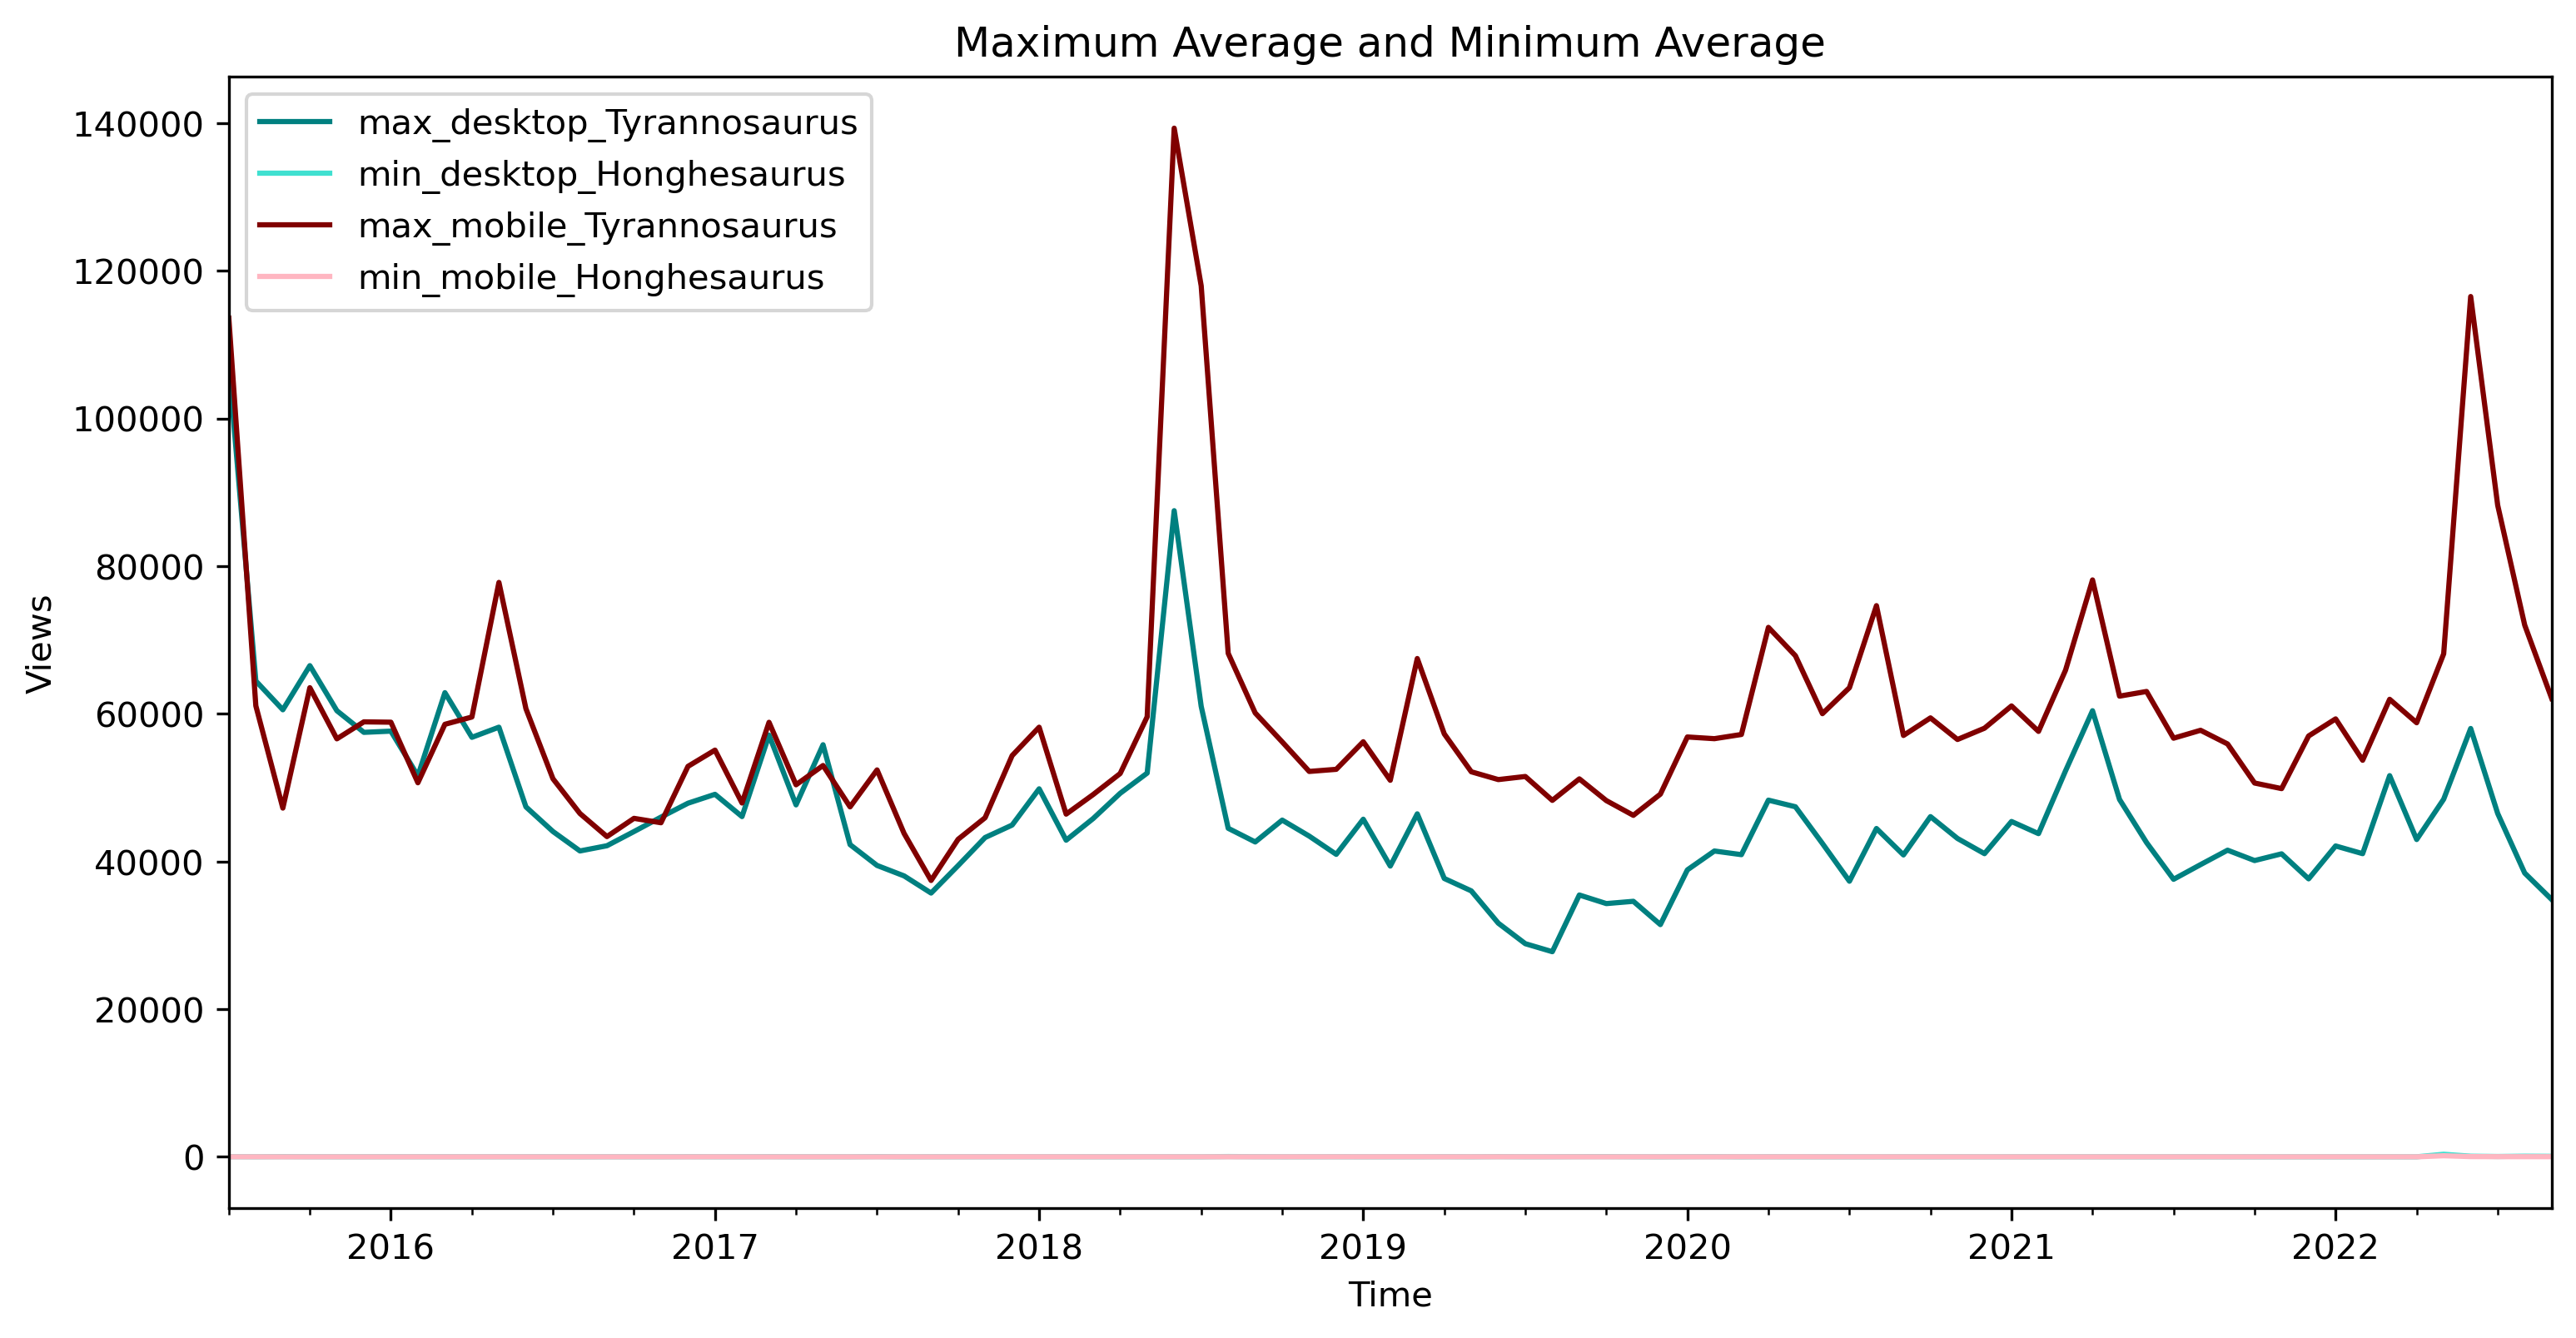

In [225]:
# Filtering each type in df_main to plot the four lines individually
fig2a = plt.gcf()
plt.figure(figsize = (12,6), dpi = 300)
df_1a = df_main[df_main['min_max']=='max_desktop']
df_1a['views'].plot(label = df_1a['label'].unique()[0], color = 'teal')

df_1b = df_main[df_main['min_max']=='min_desktop']
df_1b['views'].plot(label = df_1b['label'].unique()[0], color = 'turquoise')

df_2a = df_main[df_main['min_max']=='max_mobile']
df_2a['views'].plot(label = df_2a['label'].unique()[0], color = 'maroon')

df_2b = df_main[df_main['min_max']=='min_mobile']
df_2b['views'].plot(label = df_2b['label'].unique()[0], color = 'lightpink')

# Adding the title, axes names, legends
plt.title('Maximum Average and Minimum Average')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend()

- Saving the image as a .png to be exported

In [164]:
fig2a.savefig('step2a-minmaxavg-plot.png') 

### 2b) Top 10 Peak Page Views
The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

- To calculate the max value across all articles (dinos) and the respective month they peaked at
- Rank them and pick only the top 10 (for mobile and desktop thus giving 20 trend lines)

In [226]:
# Creating a function to do the above

def top_10(df, access):
    group_df = df.groupby('article').max('views').reset_index()
    group_df = group_df.sort_values(by='views', ascending=False)
    
    only_top10 = group_df.head(10)
    only_top10 = only_top10[['article']].reset_index()
    only_top10 = only_top10.drop('index', axis=1)
    only_top10['rank'] = pd.Series(np.arange(1,11))
    df['access'] = access
    df = df[['timestamp', 'article', 'access', 'views']]
    
    # need to join this data frame with the input dataframe passed
    df = df.merge(only_top10, on='article', how='inner', suffixes=('_left', '_right'))
    df['label'] = 'top_' + df['rank'].astype('str') + access + '_' + df['article']
    return df

- Calling the above function by passing "mobile" and "desktop" as access types and then merging the two into one dataframe for easier visualization

In [227]:
top_desktop = top_10(desktop_df, 'desktop')
top_mobile = top_10(mobile_df, 'mobile')
df_final = top_desktop.append(top_mobile)

# Setting timestamp as the index
df_final = df_final.set_index('timestamp')

- Running a loop to plot top 10 from the above created dataframe both both access types, i.e., 20 trend lines

<Figure size 432x288 with 0 Axes>

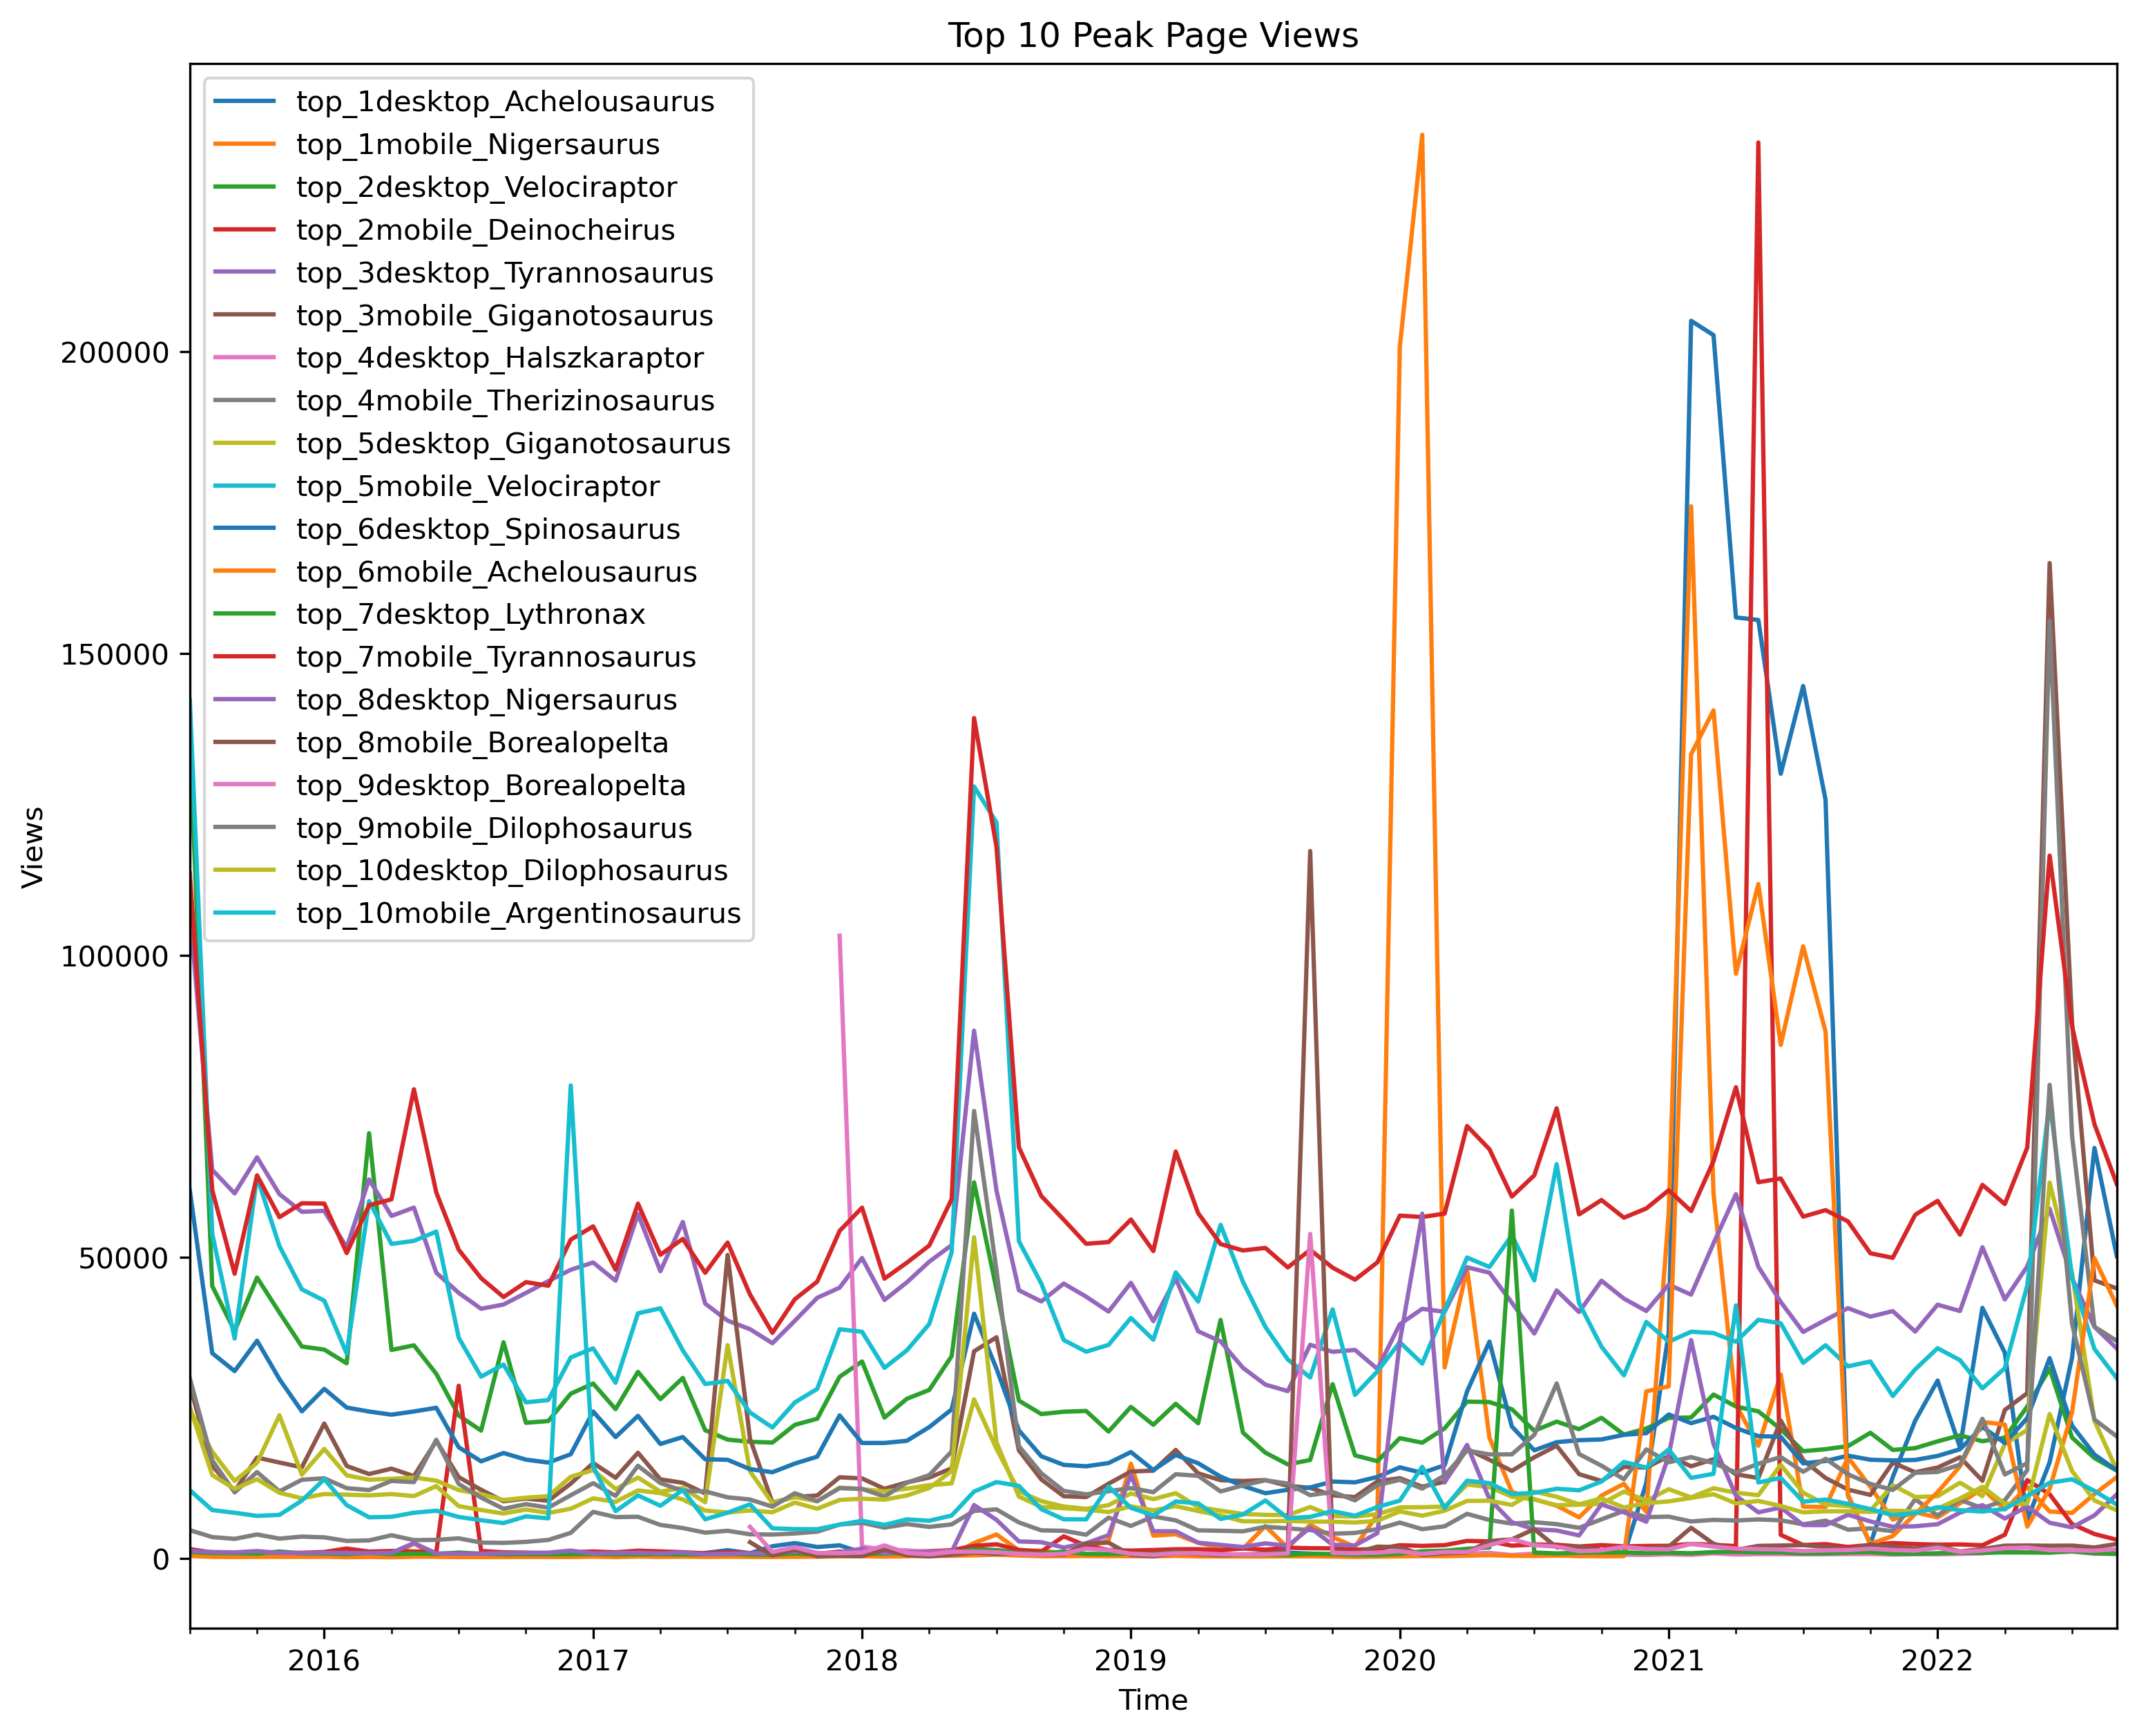

In [228]:
fig2b = plt.gcf()
plt.figure(figsize = (12,10), dpi = 300)

for i in range(1,11):
    df = df_final[df_final['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['label'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['label'].unique()[1])

# Adding the title, axes names, legends
plt.title('Top 10 Peak Page Views')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend()

- Saving the image as a .png to be exported

In [181]:
fig2b.savefig('step2b-top10peak-plot.png') 

### 2c) Fewest Months of Data
The third graph should show pages that have the fewest months of available data. These will all be relatively short time series, some may only have one month of data. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.


- we first look at the size of the timestamp available per article name (dino) and per access
- then we extract the top 10 with the fewest counts (ascending order) and rank them accordingly
- create a label column which can help in plotting the visualization

In [229]:
# defining a function to do the above steps

def fewest_df(df, access):
    few_df = df.groupby("article").count().reset_index()
    few_df = few_df[['article', 'views']]
    few_df = few_df.sort_values(by='views', ascending=True)
    
    # After sorting, storing just the top 10
    top_10 = few_df.head(10)
    top_10 = top_10[['article']].reset_index()
    top_10 = top_10.drop('index', axis = 1)
    top_10['rank'] = pd.Series(np.arange(1,11))
    
    # Adding an access column in the given dataframe
    df['access'] = access
    df = df[['timestamp', 'article', 'access', 'views']]
    
    # need to join this data frame with the input dataframe passed
    df = df.merge(top_10, on='article', how='inner', suffixes=('_left', '_right'))
    df['label'] = 'fewest_' + df['rank'].astype('str') + access + '_' + df['article']
    return df

- Calling the above function by passing "mobile" and "desktop" as access types and then merging the two into one dataframe for easier visualization

In [230]:
top_desktop = fewest_df(desktop_df, 'desktop')
top_mobile = fewest_df(mobile_df, 'mobile')
df_final = top_desktop.append(top_mobile)

# Setting timestamp as the index
df_final = df_final.set_index('timestamp')

- Running a loop to plot top 10 from the above created dataframe for both the access types thus leading to 20 trend lines.

<Figure size 432x288 with 0 Axes>

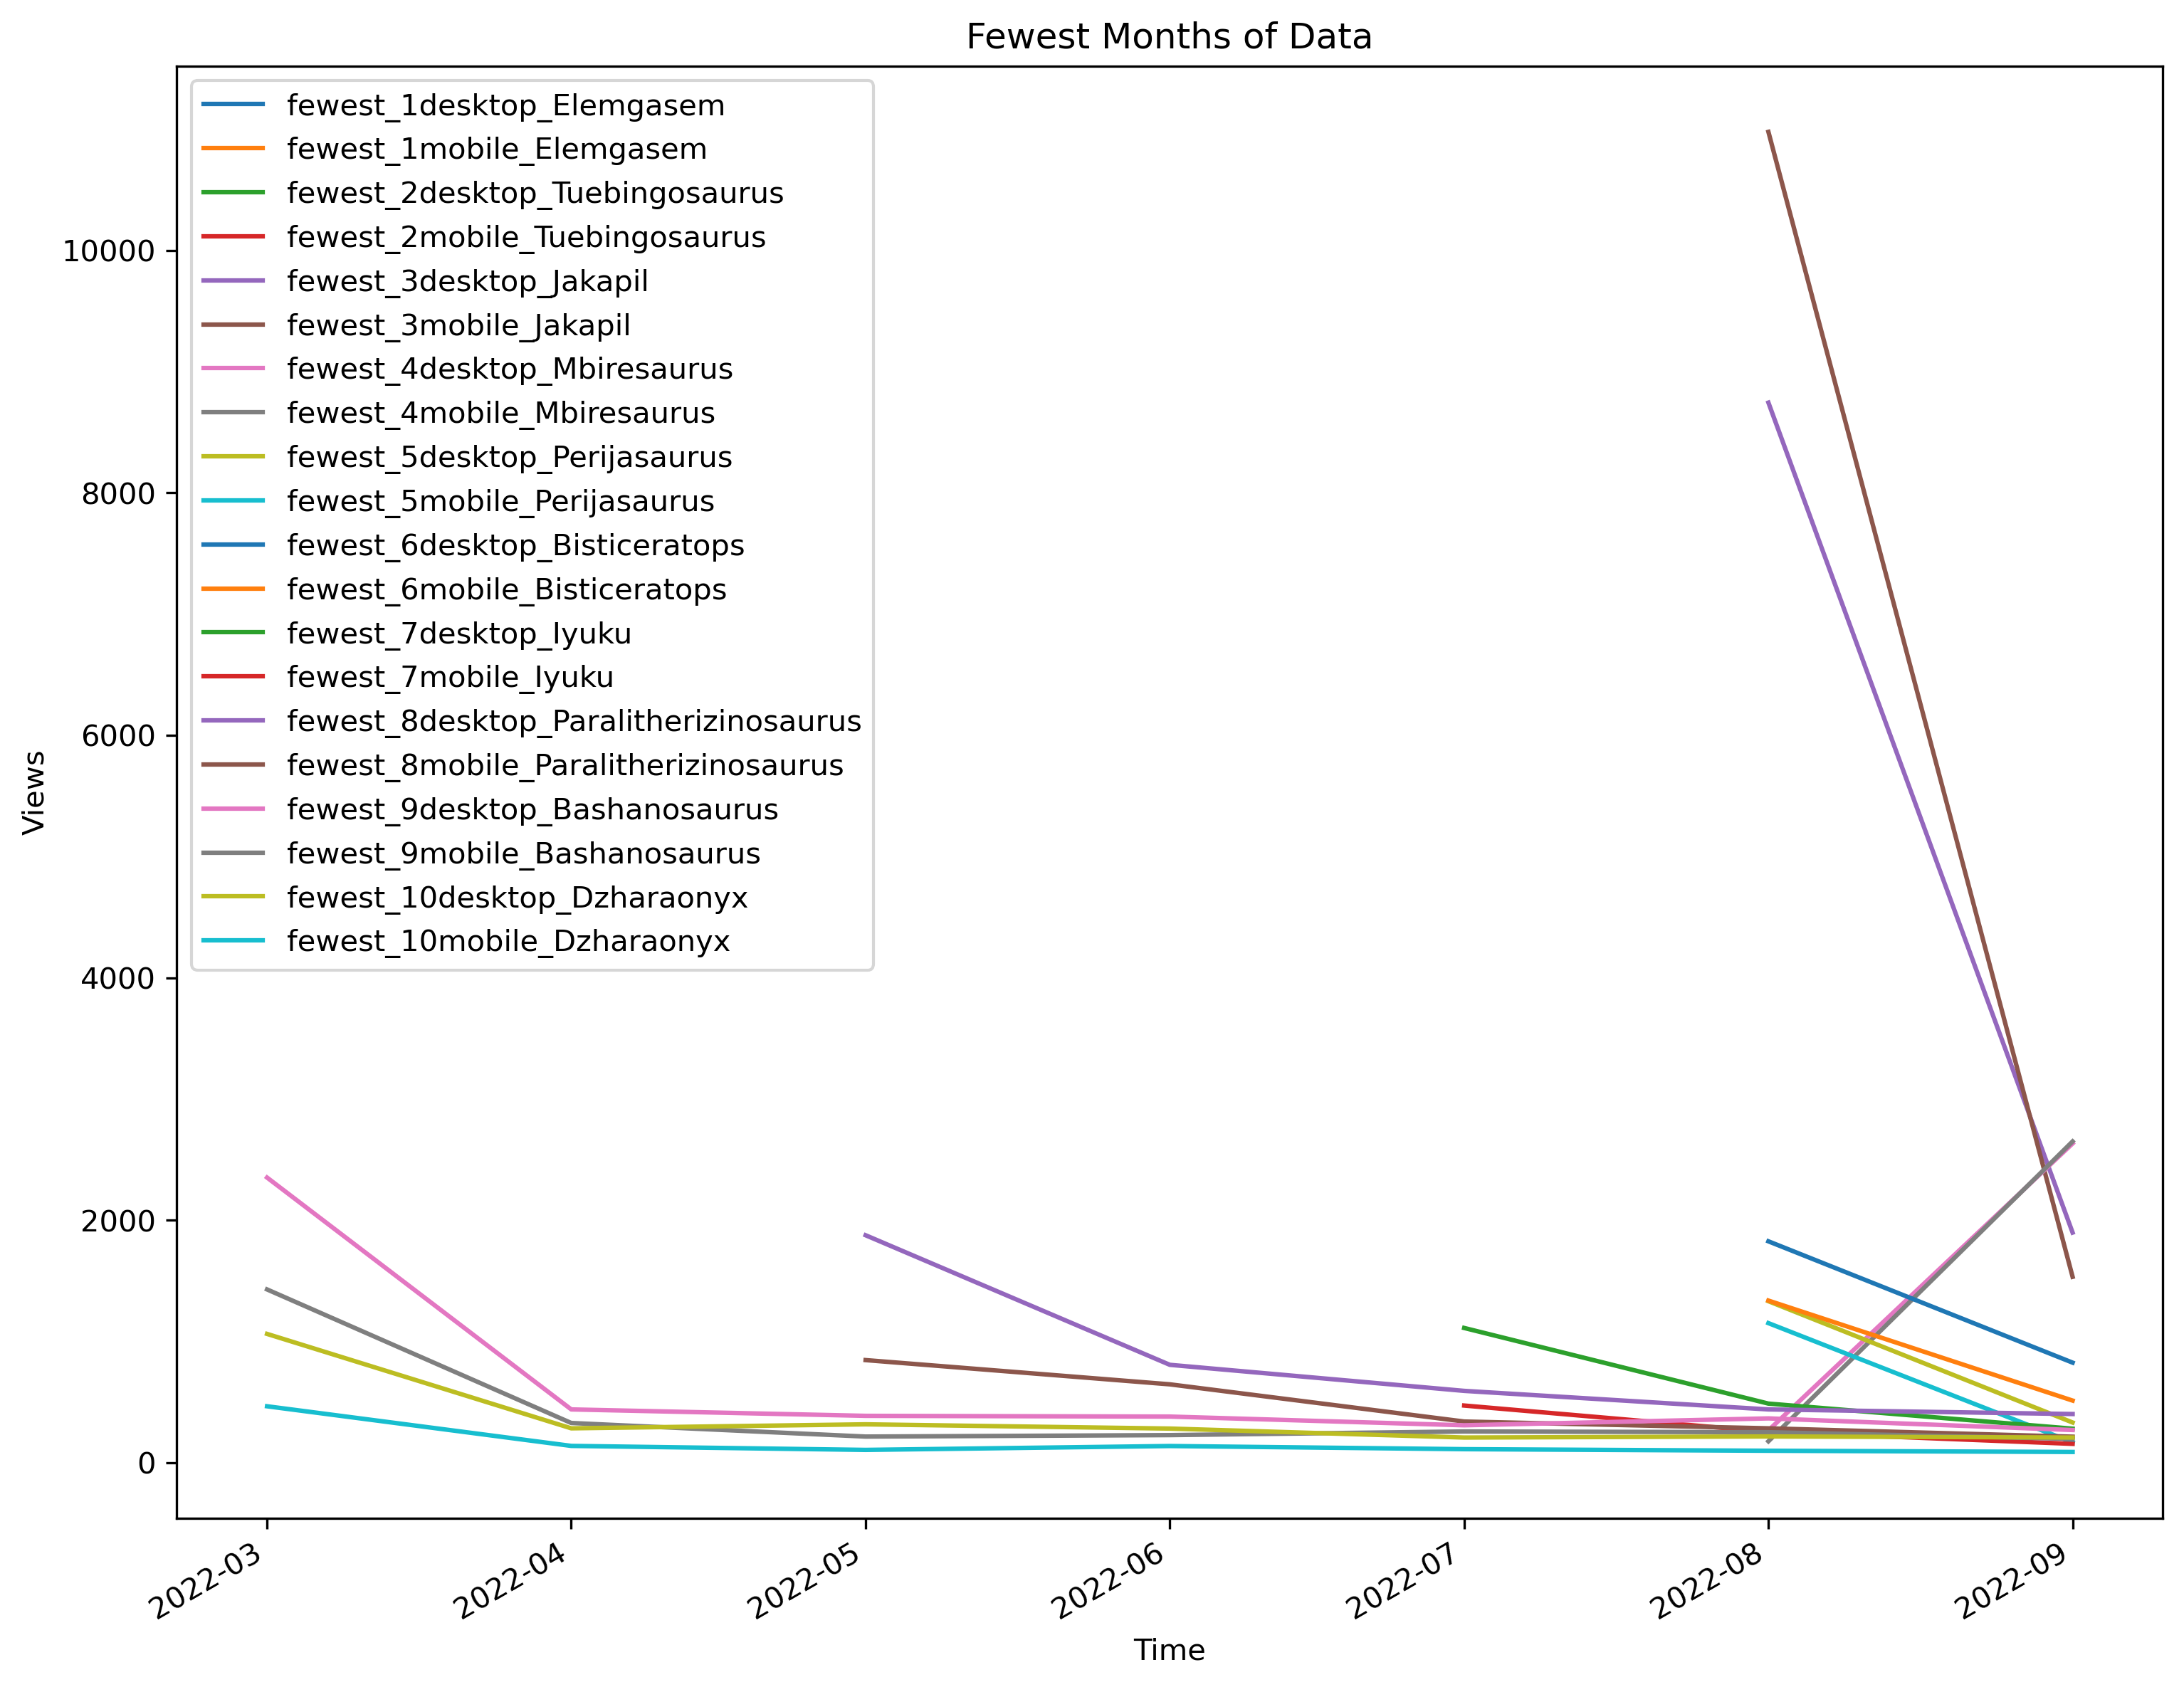

In [231]:
fig2c = plt.gcf()
plt.figure(figsize = (12,10), dpi = 300)

for i in range(1,11):
    df = df_final[df_final['rank'] == i]
    df[df['access'] == 'desktop']['views'].plot(label=df['label'].unique()[0])
    df[df['access'] == 'mobile']['views'].plot(label=df['label'].unique()[1])

# Adding the title, axes names, legends
plt.title('Fewest Months of Data')
plt.xlabel('Time')
plt.ylabel('Views')
plt.legend()

- Saving the image as a .png to be exported

In [205]:
fig2c.savefig('step2c-fewest10-plot.png') 